# Quick Dash score + VAS pain intensity
to assess whethere movement quality is related to patient reported functioning. 
We expect that movement quality post-operatively is related to patient reported disability and pain scores. 
And that there are differences in movement quality between the people with a DASH < 15 and those above 15. The threshold of 15 is chosen because this indicates whether someome is 'disabled' or not

1) Only retain t1 (1 months post-op data) 
and remove participants with to many NaN

2) Calculate the total DASH score

Berekening Quick DASH beperkingen en symptomen score:  
{(Som van de antwoorden op N items / N ) – 1} x 25 
N = aantal ingevulde antwoorden  
Let op: de Quick DASH score mag niet berekend worden als meer dan 1 vraag niet beantwoord is.


3) Split group on disabled group and non-disabled

4) Correlate the Quick Dash scores with movement quality. i.e. do people with a higher score perform better?


In [195]:
import numpy as np
import pandas as pd
import ptitprince as pt
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

#### Input data sets
1) Dash scores

In [196]:
raw = pd.read_csv("C:\\Users\\u0117545\\KU Leuven\\An De Groef - DATA\\XsensTest\\QuickDASH\\UPLIFTBC-QuickDASH_DATA_2022-10-31_1406 (1).csv",
                   sep=';')

In [197]:
# only retain T1 of the dash scores 
idx = raw['redcap_event_name'].str.contains('t1')
mask = np.where(idx)[0]
raw = raw.iloc[mask]
raw.head()

,record_id,redcap_event_name,quickdash_1,quickdash_2,quickdash_3,quickdash_4,quickdash_5,quickdash_6,quickdash_7,quickdash_8,quickdash_9,quickdash_10,quickdash_11
1,BC_001,t1_1_month_postsur_arm_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,BC_002,t1_1_month_postsur_arm_1,2.0,3.0,1.0,3.0,1.0,3.0,1.0,2.0,2.0,1.0,1.0
6,BC_003,t1_1_month_postsur_arm_1,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0
9,BC_005,t1_1_month_postsur_arm_1,3.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0
11,BC_006,t1_1_month_postsur_arm_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [198]:
# remove participants with more than 2 NaNs
# Remove rows with missing values
print("Before removing rows with missing data: {} rows".format(len(raw)))
df_dash = raw.dropna(thresh=raw.shape[1]-1, axis=0)
print("After removing rows with missing data: {} rows".format(len(df_dash)))

Before removing rows with missing data: 21 rows
After removing rows with missing data: 15 rows


2) Movement quality parameters

In [199]:
df_qual = pd.read_excel('C:/Users/u0117545/Documents/GitHub/ULIFT_BC/Output/MoveQual_aff.xlsx', sheet_name = 'T1')
df_qual.head()

,ppID,trial,time,lyapExp_x,lyapExp_y,lyapExp_z,lyapExp_res,sampen_x,sampen_y,sampen_z,...,reg_z,reg_res,rms_x,rms_y,rms_z,rms_res,rmsr_x,rmsr_y,rmsr_z,LDLJ_A
0,BC_001,F_R_001,T1,1.962892,2.043547,2.157155,3.960050,0.258534,0.786504,0.171106,...,0.368878,0.334696,0.798805,0.466922,1.260532,1.692058,0.510854,0.298607,0.806140,-7.981237
1,BC_002,F_L_001,T1,4.439682,2.725740,4.164255,1.972050,0.901541,1.034282,0.816484,...,0.631316,0.471015,1.685291,1.306603,2.330640,3.347699,0.533488,0.413612,0.737777,-7.353708
2,BC_003,F_R_001,T1,2.235361,1.359312,2.278194,2.619952,0.589866,1.490243,0.410356,...,0.845875,0.667508,2.698085,3.556400,4.374624,6.575796,0.431680,0.569006,0.699918,-6.755189
3,BC_005,F_R_001,T1,3.539106,1.808414,3.096614,0.457896,1.097793,1.189614,0.584015,...,0.852151,0.427123,1.928613,1.329724,3.294580,4.247737,0.477082,0.328934,0.814982,-6.673945
4,BC_006,F_R_001,T1,4.345403,1.733239,1.719403,3.952948,0.996575,1.456154,0.616430,...,0.585758,0.543105,2.392201,1.227160,3.379697,4.639747,0.553921,0.284152,0.782578,-7.320470


#### Calculate total dash scores

In [200]:
som = df_dash.iloc[:,2:].sum(axis='columns')
col_n_counts = np.sum(df_dash.applymap(lambda x: 0 if pd.isnull(x) else 1), axis=1)-2
complete = col_n_counts.apply(lambda x:  x >= 10 )

total_score = ((som/col_n_counts)-1) * 25

print('Average score over all participants and timepoints = {}'.format(np.mean(total_score)))
print('Maximum and minumum scores are {} & {} respectively'.format(total_score.max(), total_score.min()))



Average score over all participants and timepoints = 26.363636363636363
Maximum and minumum scores are 70.45454545454545 & 0.0 respectively


In [201]:
#set-up dataframe for total dash scores. 
d = {'ppID': df_dash['record_id'],
    'total_score': total_score}
df_totaldash = pd.DataFrame(data=d)

In [202]:
# merge the dataframes on ppID remove time and trial (since it is all 1 months post op)
# use df for all furhter analysis
df = df_totaldash.merge(df_qual)
df = df.drop(labels=['trial', 'time'], axis = 1)
df.head()

,ppID,total_score,lyapExp_x,lyapExp_y,lyapExp_z,lyapExp_res,sampen_x,sampen_y,sampen_z,sampen_res,...,reg_z,reg_res,rms_x,rms_y,rms_z,rms_res,rmsr_x,rmsr_y,rmsr_z,LDLJ_A
0,BC_001,0.000000,1.962892,2.043547,2.157155,3.960050,0.258534,0.786504,0.171106,0.258188,...,0.368878,0.334696,0.798805,0.466922,1.260532,1.692058,0.510854,0.298607,0.806140,-7.981237
1,BC_002,20.454545,4.439682,2.725740,4.164255,1.972050,0.901541,1.034282,0.816484,0.963440,...,0.631316,0.471015,1.685291,1.306603,2.330640,3.347699,0.533488,0.413612,0.737777,-7.353708
2,BC_003,15.909091,2.235361,1.359312,2.278194,2.619952,0.589866,1.490243,0.410356,0.517863,...,0.845875,0.667508,2.698085,3.556400,4.374624,6.575796,0.431680,0.569006,0.699918,-6.755189
3,BC_005,29.545455,3.539106,1.808414,3.096614,0.457896,1.097793,1.189614,0.584015,0.882556,...,0.852151,0.427123,1.928613,1.329724,3.294580,4.247737,0.477082,0.328934,0.814982,-6.673945
4,BC_006,0.000000,4.345403,1.733239,1.719403,3.952948,0.996575,1.456154,0.616430,0.750033,...,0.585758,0.543105,2.392201,1.227160,3.379697,4.639747,0.553921,0.284152,0.782578,-7.320470


#### 3) Split group on disabled group and non-disabled

In [203]:
# find the people with a dash score higher than 15
idx = df['total_score'] >= 15
mask = np.where(idx)[0]
pain = df.iloc[mask]
pain['group'] = 1

# find the people with a dash score lower than 15
idx = df['total_score'] < 15
mask = np.where(idx)[0]
no_pain = df.iloc[mask]
no_pain['group'] = 0

print('number of people with perceived disablity: {}'.format(len(pain)))
print('number of people with no perceived disablity: {}'.format(len(no_pain)))

number of people with perceived disablity: 9
number of people with no perceived disablity: 6


In [204]:
df2 = pd.concat([pain, no_pain], axis=0, ignore_index=True)
df2

,ppID,total_score,lyapExp_x,lyapExp_y,lyapExp_z,lyapExp_res,sampen_x,sampen_y,sampen_z,sampen_res,...,reg_res,rms_x,rms_y,rms_z,rms_res,rmsr_x,rmsr_y,rmsr_z,LDLJ_A,group
0,BC_002,20.454545,4.439682,2.725740,4.164255,1.972050,0.901541,1.034282,0.816484,0.963440,...,0.471015,1.685291,1.306603,2.330640,3.347699,0.533488,0.413612,0.737777,-7.353708,1
1,BC_003,15.909091,2.235361,1.359312,2.278194,2.619952,0.589866,1.490243,0.410356,0.517863,...,0.667508,2.698085,3.556400,4.374624,6.575796,0.431680,0.569006,0.699918,-6.755189,1
2,BC_005,29.545455,3.539106,1.808414,3.096614,0.457896,1.097793,1.189614,0.584015,0.882556,...,0.427123,1.928613,1.329724,3.294580,4.247737,0.477082,0.328934,0.814982,-6.673945,1
3,BC_007,52.272727,2.346777,1.227715,3.071512,1.725340,0.902467,1.101804,0.662207,0.993165,...,0.663705,2.381153,1.611861,3.200631,4.541092,0.553427,0.374628,0.743890,-6.522885,1
4,BC_010,65.909091,2.859818,1.890129,3.259697,2.871494,0.967338,0.729688,0.653904,0.866703,...,0.647854,2.258986,2.850676,3.747127,5.542285,0.432582,0.545887,0.717552,-6.592884,1
5,BC_014,31.818182,2.911912,1.480595,3.116100,1.822404,0.783732,0.623639,0.382161,0.806452,...,0.491295,2.051499,1.500342,3.013309,4.211295,0.520415,0.380600,0.764403,-6.882059,1
6,BC_015,59.090909,3.333666,3.326168,2.694549,2.280530,1.017540,1.151159,0.707833,1.090691,...,0.658816,3.032299,1.909733,4.262346,5.890270,0.544533,0.342946,0.765423,-6.137404,1
7,BC_020,70.454545,3.214771,1.606040,3.381548,2.948919,0.711856,0.747758,0.484300,0.768494,...,0.478647,1.967139,1.790949,2.833569,4.233652,0.506124,0.460792,0.729047,-6.735840,1
8,BC_021,20.454545,2.939057,0.775445,3.315594,0.615027,0.729378,0.520428,0.439894,0.810450,...,0.360456,2.229836,0.968976,3.123296,4.137893,0.563369,0.244812,0.789102,-6.938287,1
9,BC_001,0.000000,1.962892,2.043547,2.157155,3.960050,0.258534,0.786504,0.171106,0.258188,...,0.334696,0.798805,0.466922,1.260532,1.692058,0.510854,0.298607,0.806140,-7.981237,0


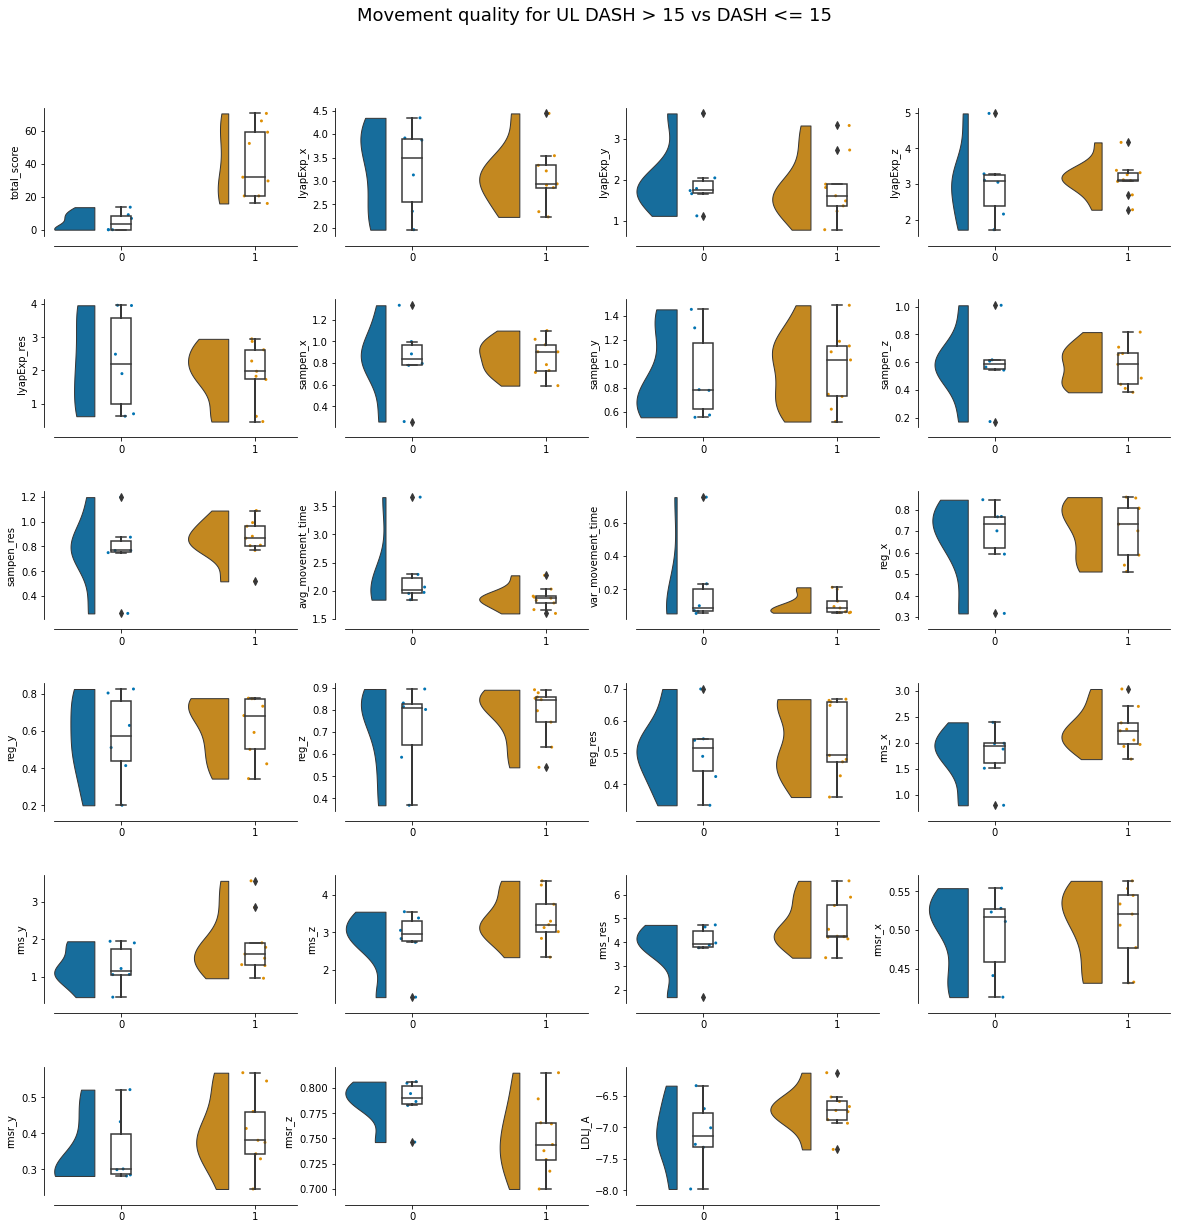

In [205]:
# plot the results
X = df2.drop(['ppID', 'group'], axis = 1)
# find minimium required rows given we want 5 columns
ncols = 4
nrows = len(X.columns) // ncols + (len(X.columns) % ncols > 0)
dx = "group"; ort = "v"; pal = 'colorblind'; sigma = .6; viol = .6; mv = .0

f = plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Movement quality for UL DASH > 15 vs DASH <= 15", fontsize=18, y=0.95)

f.tight_layout();
offset = 0.1;

for n, columns in enumerate(X.columns):
    # add a new subplot iteratively
    ax = plt.subplot(nrows, ncols, n + 1)
    
    # filter df and plot ticker on the new subplot axis
    #df[df["ticker"] == ticker].plot(ax=ax)
     
    pt.RainCloud(x = dx, y = columns, data = df2, ax = ax,
                palette = pal, bw = sigma, width_viol = viol,
                orient = ort, move = mv)
    sns.despine(offset=10)
    ax.set_xlabel('')

In [206]:
for var in df2.columns:
    print('Analyzing {}'.format(var))
    if var == 'ppID' or var == 'group':
        print(80 * '_' + '\n')
    else:
        t_statistic, pvalue = stats.mannwhitneyu(pain[var], no_pain[var])
        print(t_statistic, round(pvalue, ndigits=4))
        
        print(80* "_" + "\n" )
        

Analyzing ppID
________________________________________________________________________________

Analyzing total_score
54.0 0.0017
________________________________________________________________________________

Analyzing lyapExp_x
23.0 0.6889
________________________________________________________________________________

Analyzing lyapExp_y
22.0 0.607
________________________________________________________________________________

Analyzing lyapExp_z
33.0 0.5287
________________________________________________________________________________

Analyzing lyapExp_res
22.0 0.607
________________________________________________________________________________

Analyzing sampen_x
27.0 1.0
________________________________________________________________________________

Analyzing sampen_y
28.0 0.9546
________________________________________________________________________________

Analyzing sampen_z
27.0 1.0
________________________________________________________________________________

# set up data for logistic regression and subsequent AUC ROC analysis

In [207]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import *
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.linear_model import *
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [208]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ppID               15 non-null     object 
 1   total_score        15 non-null     float64
 2   lyapExp_x          15 non-null     float64
 3   lyapExp_y          15 non-null     float64
 4   lyapExp_z          15 non-null     float64
 5   lyapExp_res        15 non-null     float64
 6   sampen_x           15 non-null     float64
 7   sampen_y           15 non-null     float64
 8   sampen_z           15 non-null     float64
 9   sampen_res         15 non-null     float64
 10  avg_movement_time  15 non-null     float64
 11  var_movement_time  15 non-null     float64
 12  reg_x              15 non-null     float64
 13  reg_y              15 non-null     float64
 14  reg_z              15 non-null     float64
 15  reg_res            15 non-null     float64
 16  rms_x              15 non-nu

In [209]:
df2.describe()

,total_score,lyapExp_x,lyapExp_y,lyapExp_z,lyapExp_res,sampen_x,sampen_y,sampen_z,sampen_res,avg_movement_time,...,reg_res,rms_x,rms_y,rms_z,rms_res,rmsr_x,rmsr_y,rmsr_z,LDLJ_A,group
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,26.363636,3.160006,1.876821,3.111096,2.061656,0.849469,0.936302,0.576788,0.821137,2.039125,...,0.526344,2.052301,1.634227,3.131558,4.359892,0.502165,0.385336,0.765505,-6.881909,0.600000
std,24.490077,0.760480,0.787919,0.777867,1.133655,0.243047,0.330462,0.195829,0.223130,0.488468,...,0.117688,0.516625,0.769082,0.754813,1.129920,0.050327,0.102640,0.035134,0.460184,0.507093
min,0.000000,1.962892,0.775445,1.719403,0.457896,0.258534,0.520428,0.171106,0.258188,1.594048,...,0.334696,0.798805,0.466922,1.260532,1.692058,0.413147,0.244812,0.699918,-7.981237,0.000000
25%,7.954545,2.607374,1.419954,2.871198,1.208403,0.753237,0.676664,0.462097,0.767347,1.832921,...,0.449069,1.903637,1.148770,2.830376,3.923196,0.459014,0.299671,0.740833,-7.142191,0.000000
50%,20.454545,3.129047,1.733239,3.106436,1.972050,0.882679,0.786504,0.584015,0.810450,1.901190,...,0.491295,1.989299,1.500342,3.123296,4.233652,0.520415,0.374628,0.765423,-6.755189,1.000000
75%,42.045455,3.705079,1.966838,3.298846,2.745723,0.981956,1.170387,0.658056,0.922998,2.045238,...,0.653335,2.320069,1.908608,3.463953,4.682737,0.539011,0.446610,0.791714,-6.633414,1.000000
max,70.454545,4.439682,3.621872,4.975438,3.960050,1.331502,1.490243,1.010028,1.199183,3.665152,...,0.699402,3.032299,3.556400,4.374624,6.575796,0.563369,0.569006,0.814982,-6.137404,1.000000


In [210]:
df2['group'].value_counts()

1    9
0    6
Name: group, dtype: int64

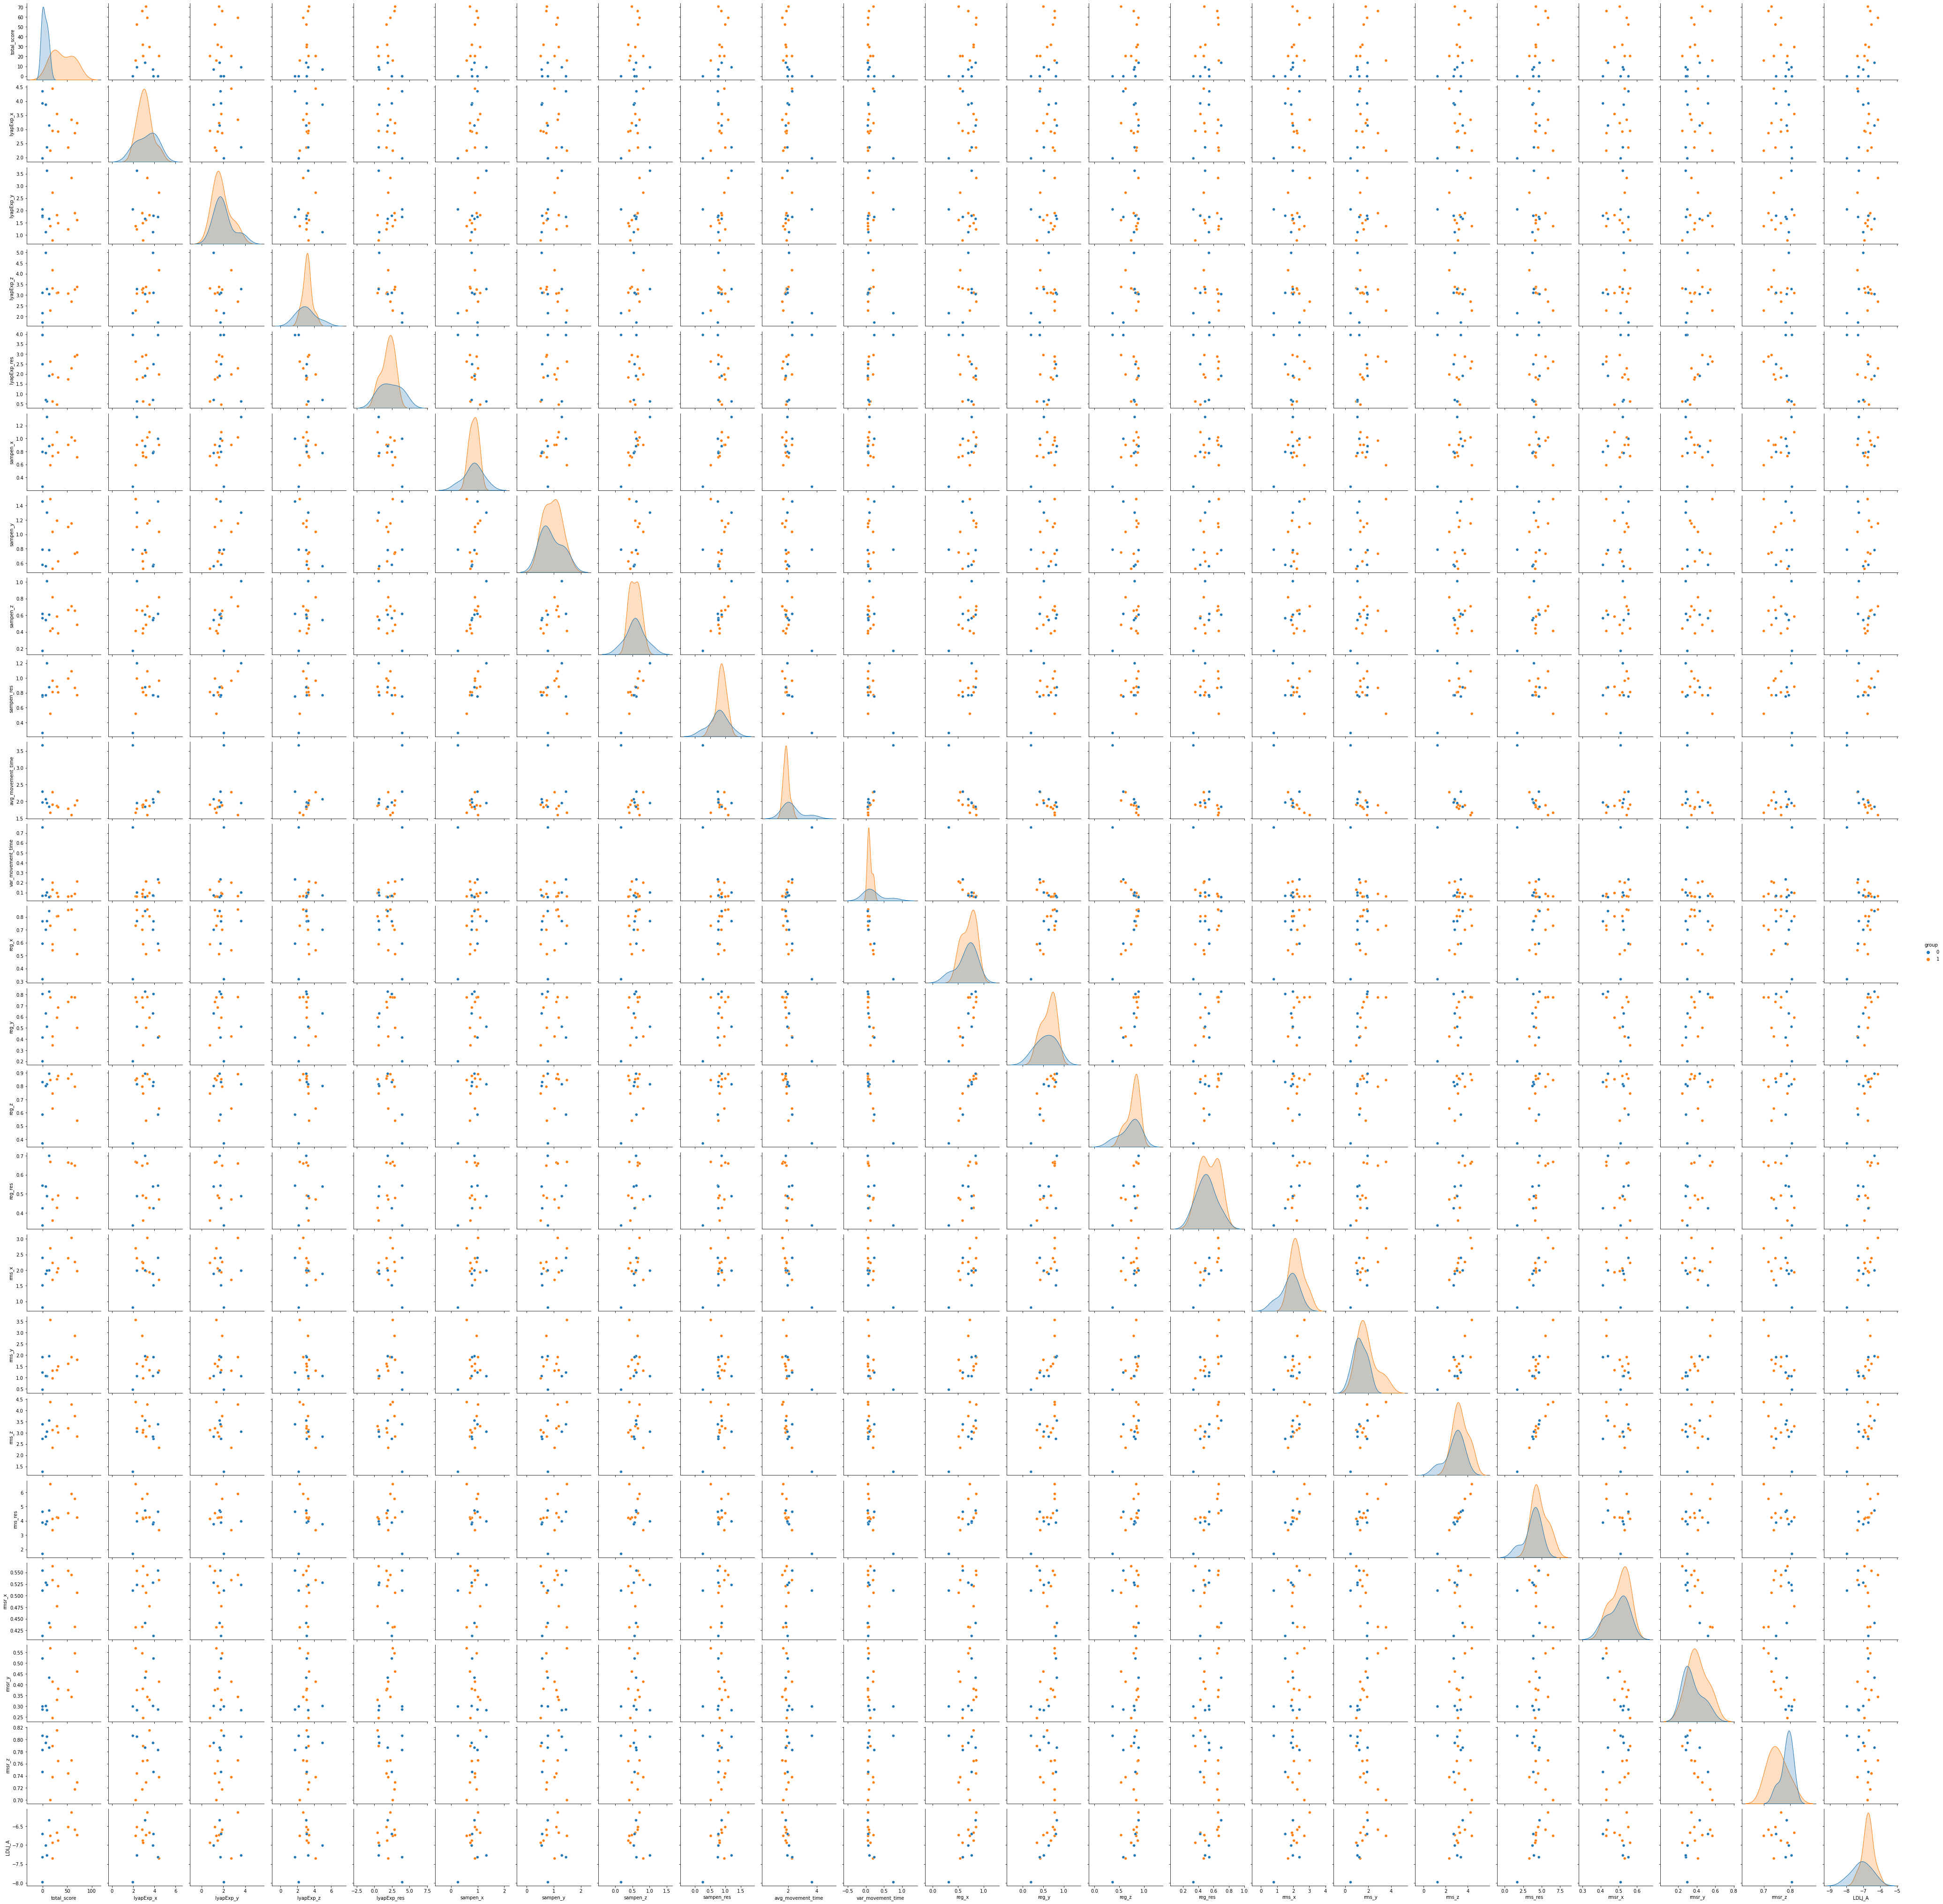

In [211]:
sns.pairplot(df2, hue='group')

In [212]:
df2['product'] = df2['LDLJ_A'] * df2['sampen_res']
df2['ratio'] = df2['sampen_res'] / df2['LDLJ_A']
df2.head()

,ppID,total_score,lyapExp_x,lyapExp_y,lyapExp_z,lyapExp_res,sampen_x,sampen_y,sampen_z,sampen_res,...,rms_y,rms_z,rms_res,rmsr_x,rmsr_y,rmsr_z,LDLJ_A,group,product,ratio
0,BC_002,20.454545,4.439682,2.725740,4.164255,1.972050,0.901541,1.034282,0.816484,0.963440,...,1.306603,2.330640,3.347699,0.533488,0.413612,0.737777,-7.353708,1,-7.084854,-0.131014
1,BC_003,15.909091,2.235361,1.359312,2.278194,2.619952,0.589866,1.490243,0.410356,0.517863,...,3.556400,4.374624,6.575796,0.431680,0.569006,0.699918,-6.755189,1,-3.498264,-0.076662
2,BC_005,29.545455,3.539106,1.808414,3.096614,0.457896,1.097793,1.189614,0.584015,0.882556,...,1.329724,3.294580,4.247737,0.477082,0.328934,0.814982,-6.673945,1,-5.890129,-0.132239
3,BC_007,52.272727,2.346777,1.227715,3.071512,1.725340,0.902467,1.101804,0.662207,0.993165,...,1.611861,3.200631,4.541092,0.553427,0.374628,0.743890,-6.522885,1,-6.478299,-0.152259
4,BC_010,65.909091,2.859818,1.890129,3.259697,2.871494,0.967338,0.729688,0.653904,0.866703,...,2.850676,3.747127,5.542285,0.432582,0.545887,0.717552,-6.592884,1,-5.714073,-0.131460


<AxesSubplot:xlabel='ratio', ylabel='total_score'>

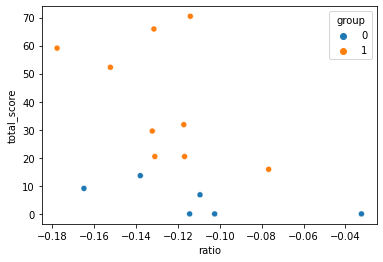

In [213]:
sns.scatterplot(x='ratio', y='total_score', data = df2, hue = 'group')

<AxesSubplot:>

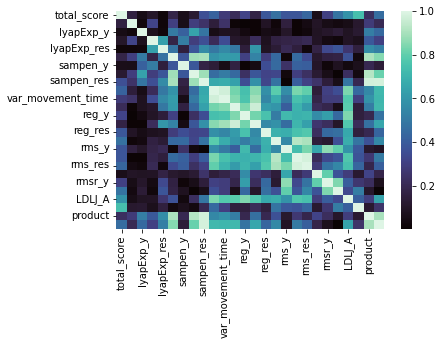

In [214]:
sns.heatmap(abs(df2.corr()), cmap="mako")

Accuracy: 40.0%


,0,1
0,0,3
1,0,2


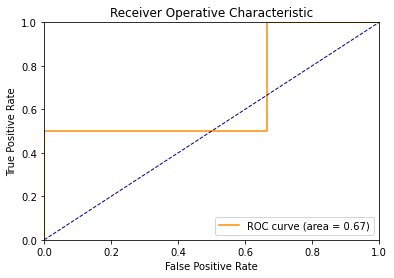

In [215]:
regularization_path = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

#set X and y
X = df2.drop(['ppID', 'total_score', 'group'],axis=1)
y = df2['group']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

# Standardize
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Logistic regression
prev_accuracy = 0
prev_C = None

for C in regularization_path:
    pipeline = LogisticRegression(penalty = 'l2', solver = 'liblinear', C=C)
    model = pipeline.fit(X_train, y_train)
    n = (model.coef_ != 0).sum()
    accuracy = model.score(X_train, y_train)
    if accuracy < prev_accuracy: break
    prev_accuracy = accuracy
    prev_C = C
    
pipeline = LogisticRegression(penalty='l2', solver = 'liblinear', C=prev_C)
model = pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print('Accuracy: {}%'.format(accuracy_score(y_test, y_pred)*100))
        
# Confusion Matrix 
m = pd.DataFrame(confusion_matrix(y_test, y_pred))
display(m)

# ROC and AUC
y_score = pipeline.decision_function(X_test)
probs = model.predict_proba(X_test)
probs = probs[:,1]
fpr = dict()
tpr = dict()
roc_auc = dict()
# compute ROC curve and AUC for each class 
fpr[0], tpr[0], _ = roc_curve(y_test[:], probs[:])
roc_auc[0] = auc(fpr[0], tpr[0])

# plot the ROC curve
plt.figure()
plt.plot(fpr[0], tpr[0], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color= 'navy', lw = 1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operative Characteristic')
plt.legend(loc='lower right')
plt.show()

In [216]:
model.coef_

array([[-0.00064853,  0.02889273, -0.05463053,  0.01526703,  0.0564299 ,
         0.05707453,  0.03001006,  0.07632971, -0.10112261, -0.06019336,
        -0.02798451, -0.04652367, -0.00739821, -0.08003789,  0.12240973,
         0.07727788,  0.06346072,  0.08965549,  0.0858789 ,  0.06857976,
        -0.1975026 ,  0.02032118, -0.09363217, -0.05801044]])

In [217]:
len(X.columns)

24

In [218]:
coeficients = pd.DataFrame({'feature_name':X.columns,
                          'model.coef': model.coef_[0]})

In [219]:
coeficients

,feature_name,model.coef
0,lyapExp_x,-0.000649
1,lyapExp_y,0.028893
2,lyapExp_z,-0.054631
3,lyapExp_res,0.015267
4,sampen_x,0.056430
5,sampen_y,0.057075
6,sampen_z,0.030010
7,sampen_res,0.076330
8,avg_movement_time,-0.101123
9,var_movement_time,-0.060193
